# 16-6. 프로젝트 - Movielens 영화 SBR

In [1]:
!ls # Movielens 1M Dataset 기반으로, Session based Recommendation 시스템을 제작!

220307_exp16_next_movie_project.ipynb  aiffel  data


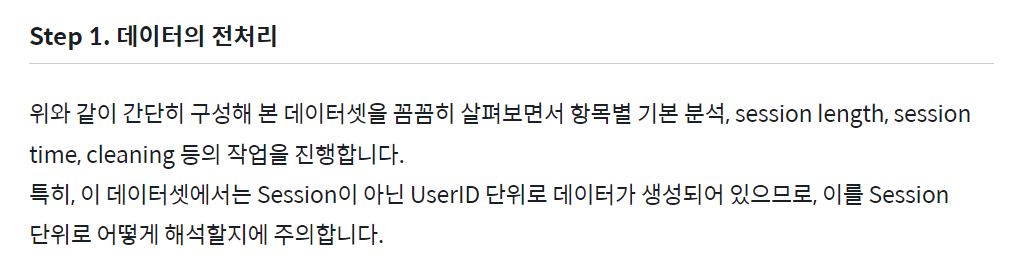

https://biology-statistics-programming.tistory.com/47

In [6]:
# 데이터 설명(README)를 읽어 봅니다. 
import os
import pandas as pd
f = open(os.getenv('HOME')+'/aiffel/yoochoose/data/dataset-README.txt', 'r')
while True:
    line = f.readline()
    if not line: break
    print(line)
f.close()

﻿SUMMARY




This dataset was constructed by YOOCHOOSE GmbH to support participants in the RecSys Challenge 2015.

See  http://recsys.yoochoose.net for details about the challenge.



The YOOCHOOSE dataset contain a collection of sessions from a retailer, where each session

is encapsulating the click events that the user performed in the session.

For some of the sessions, there are also buy events; means that the session ended

with the user bought something from the web shop. The data was collected during several

months in the year of 2014, reflecting the clicks and purchases performed by the users

of an on-line retailer in Europe.  To protect end users privacy, as well as the retailer,

all numbers have been modified. Do not try to reveal the identity of the retailer.



LICENSE


This dataset is licensed under the Creative Commons Attribution-NonCommercial-NoDerivatives 4.0

International License. To view a copy of this license, visit http://creativecommons.org/licenses/by-nc-nd

In [7]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [14]:
from pathlib import Path # pathlib 문서 참고해서 공부해보기
import numpy as np

In [68]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Timestamp']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Timestamp'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

/opt/conda/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,UserId,ItemId,Rating,Timestamp
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


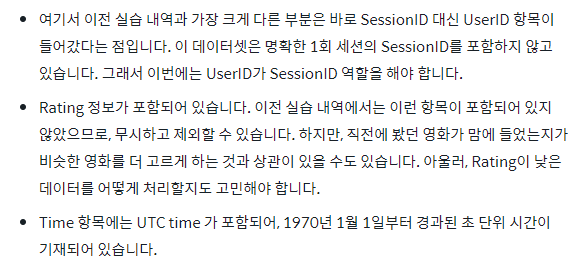

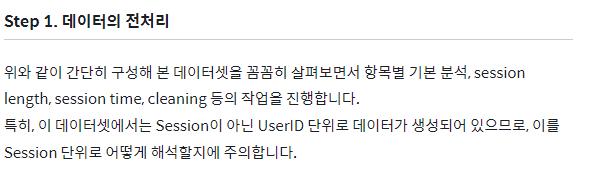

In [19]:
print( data['UserId'].nunique(),data['ItemId'].nunique())

6040 3706


In [20]:
data['UserId'].value_counts(), data['ItemId'].value_counts()

(4169    2314
 1680    1850
 4277    1743
 1941    1595
 1181    1521
         ... 
 5725      20
 3407      20
 1664      20
 4419      20
 3021      20
 Name: UserId, Length: 6040, dtype: int64,
 2858    3428
 260     2991
 1196    2990
 1210    2883
 480     2672
         ... 
 790        1
 1386       1
 655        1
 3312       1
 2909       1
 Name: ItemId, Length: 3706, dtype: int64)

In [21]:
# 각 유저별 사람들이 리뷰를 남긴 개수
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [22]:
session_length.describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
dtype: float64

가장 적게 남긴 사람은 20이다. 왜냐하면 리뷰를 20개 이상 남긴 사람만 모아둔 데이터이기 때문이다.

## 데이터 전처리 1: Timestamp ->Date

In [26]:
# >>> from datetime import timedelta

len(data['Timestamp'])

1000209

In [27]:
data

,UserId,ItemId,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [28]:
import time
from datetime import datetime

date =[]

for i in range(1000209):
    time = datetime.fromtimestamp(data['Timestamp'][i]).strftime('%Y-%m-%d %H:%M:%S')
    time = datetime.strptime(time, '%Y-%m-%d %H:%M:%S') # datetime 으로 변환
    date.append(time)

In [29]:
data['Time'] = date

In [30]:
data

,UserId,ItemId,Rating,Timestamp,Time
0,1,1193,5,978300760,2000-12-31 22:12:40
1,1,661,3,978302109,2000-12-31 22:35:09
2,1,914,3,978301968,2000-12-31 22:32:48
3,1,3408,4,978300275,2000-12-31 22:04:35
4,1,2355,5,978824291,2001-01-06 23:38:11
...,...,...,...,...,...
1000204,6040,1091,1,956716541,2000-04-26 02:35:41
1000205,6040,1094,5,956704887,2000-04-25 23:21:27
1000206,6040,562,5,956704746,2000-04-25 23:19:06
1000207,6040,1096,4,956715648,2000-04-26 02:20:48


In [31]:
data.drop('Timestamp', axis=1, inplace=True)

In [32]:
data

,UserId,ItemId,Rating,Time
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11
...,...,...,...,...
1000204,6040,1091,1,2000-04-26 02:35:41
1000205,6040,1094,5,2000-04-25 23:21:27
1000206,6040,562,5,2000-04-25 23:19:06
1000207,6040,1096,4,2000-04-26 02:20:48


Time을 년월일시로 바꾸었다.

추천 시스템을 만들 예정이다. 그래서 현재 주어진 데이터를 보면 평점이 별 5개 만점으로 되어 있는 듯하다. 여기에서 평점 4,5점만 남기고자 한다.

In [34]:
orginal_data_size = len(data)
print("original: ", orginal_data_size)

original:  1000209


In [35]:
data = data[data['Rating'] >=  4] # 평점 4,5점만 추천하기 위한 처리
filtered_data_size = len(data)

In [36]:
print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 575281
Ratio of Remaining Data is 57.52%


In [38]:
data


,UserId,ItemId,Rating,Time
0,1,1193,5,2000-12-31 22:12:40
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11
6,1,1287,5,2000-12-31 22:33:59
7,1,2804,5,2000-12-31 22:11:59
...,...,...,...,...
1000202,6040,1089,4,2000-04-25 23:23:16
1000205,6040,1094,5,2000-04-25 23:21:27
1000206,6040,562,5,2000-04-25 23:19:06
1000207,6040,1096,4,2000-04-26 02:20:48


In [51]:
new_session = data.groupby(['UserId', 'Time'])['ItemId'].size().reset_index()
new_session.reset_index(inplace = True)
new_session

,index,UserId,Time,ItemId
0,0,1,2000-12-31 22:00:19,1
1,1,1,2000-12-31 22:00:55,3
2,2,1,2000-12-31 22:02:52,1
3,3,1,2000-12-31 22:04:35,1
4,4,1,2000-12-31 22:11:59,2
...,...,...,...,...
330592,330592,6040,2001-08-10 14:39:27,1
330593,330593,6040,2001-08-10 14:39:58,1
330594,330594,6040,2001-08-10 14:40:29,1
330595,330595,6040,2001-08-10 14:41:04,1


In [52]:
data = pd.merge(data, new_session, on = ['UserId', 'Time'])
data

,UserId,ItemId_x,Rating,Time,index,ItemId_y
0,1,1193,5,2000-12-31 22:12:40,5,2
1,1,260,4,2000-12-31 22:12:40,5,2
2,1,3408,4,2000-12-31 22:04:35,3,1
3,1,2355,5,2001-01-06 23:38:11,28,3
4,1,2294,4,2001-01-06 23:38:11,28,3
...,...,...,...,...,...,...
575276,6040,549,4,2000-04-25 23:19:06,330480,2
575277,6040,562,5,2000-04-25 23:19:06,330480,2
575278,6040,2022,5,2000-04-26 02:30:07,330511,1
575279,6040,1094,5,2000-04-25 23:21:27,330483,1


In [53]:
data.drop('ItemId_x', axis=1, inplace=True)
data.rename(columns={'index':'SessionId'}, inplace=True)
data.rename(columns={'ItemId_y':'ItemId'}, inplace=True)
data

,UserId,Rating,Time,SessionId,ItemId
0,1,5,2000-12-31 22:12:40,5,2
1,1,4,2000-12-31 22:12:40,5,2
2,1,4,2000-12-31 22:04:35,3,1
3,1,5,2001-01-06 23:38:11,28,3
4,1,4,2001-01-06 23:38:11,28,3
...,...,...,...,...,...
575276,6040,4,2000-04-25 23:19:06,330480,2
575277,6040,5,2000-04-25 23:19:06,330480,2
575278,6040,5,2000-04-26 02:30:07,330511,1
575279,6040,5,2000-04-25 23:21:27,330483,1


In [54]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 575281 entries, 0 to 575280
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   UserId     575281 non-null  int32         
 1   Rating     575281 non-null  int32         
 2   Time       575281 non-null  datetime64[ns]
 3   SessionId  575281 non-null  int64         
 4   ItemId     575281 non-null  int64         
dtypes: datetime64[ns](1), int32(2), int64(2)
memory usage: 21.9 MB


In [57]:
import datetime as dt

two_years_ago = latest - dt.timedelta(730) # 2년 전 이전 날짜
data[data['Time'] > two_years_ago] # 확인

,UserId,Rating,Time,SessionId,ItemId
1471,19,4,2001-07-08 01:43:18,933,1
1539,19,5,2001-07-08 01:43:56,934,1
1548,20,4,2001-12-29 23:38:35,943,1
1549,20,4,2001-12-29 23:39:41,945,3
1550,20,5,2001-12-29 23:39:41,945,3
...,...,...,...,...,...
575244,6040,4,2001-08-10 14:36:52,330590,1
575251,6040,4,2001-08-10 14:39:09,330591,1
575252,6040,4,2001-08-10 14:39:27,330592,1
575256,6040,4,2001-08-10 14:35:40,330587,1


In [58]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

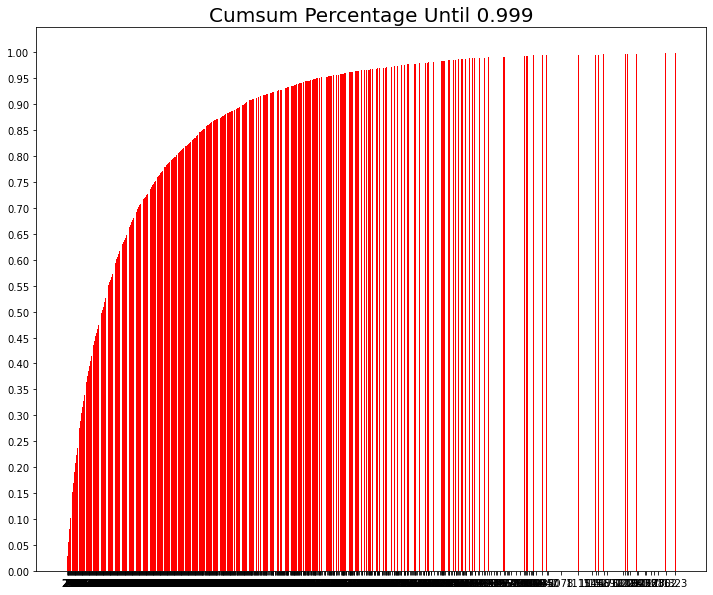

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

## data cleansing

In [59]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [60]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,Rating,Time,SessionId,ItemId
0,1,5,2000-12-31 22:12:40,5,2
1,1,4,2000-12-31 22:12:40,5,2
3,1,5,2001-01-06 23:38:11,28,3
4,1,4,2001-01-06 23:38:11,28,3
5,1,4,2001-01-06 23:38:11,28,3
...,...,...,...,...,...
575243,6040,5,2000-06-14 08:36:37,330548,2
575266,6040,4,2000-05-07 16:35:22,330537,2
575267,6040,4,2000-05-07 16:35:22,330537,2
575276,6040,4,2000-04-25 23:19:06,330480,2


## Train/Valid/Test split

In [61]:
tr = data[:200000]
val = data[200000:300000]
test = data[300000:]

In [62]:
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [63]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 200000
	 Sessions: 71328
	 Items: 20
	 First Time : 2000-09-08 02:21:19
	 Last Time : 2003-02-21 22:31:44

* valid Set Stats Info
	 Events: 100000
	 Sessions: 35552
	 Items: 16
	 First Time : 2000-07-12 04:02:26
	 Last Time : 2003-02-25 19:06:15

* test Set Stats Info
	 Events: 80783
	 Sessions: 29219
	 Items: 16
	 First Time : 2000-04-25 23:05:54
	 Last Time : 2003-02-27 17:45:48



In [64]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로
# train data를 기준으로 인덱싱 해줍니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))
    # id2idx에 없는 아이템은 모르는 값(-1) 처리
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

/tmp/ipykernel_292/4136530950.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))


In [65]:
print(tr.shape)
print(val.shape)
print(test.shape)

(200000, 6)
(100000, 6)
(80783, 6)


In [67]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

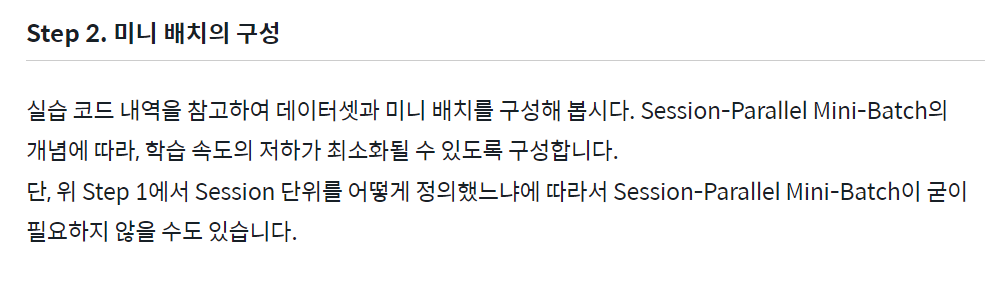

In [70]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [71]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,Rating,Time,SessionId,ItemId,item_idx
0,1,5,2000-12-31 22:12:40,5,2,0
1,1,4,2000-12-31 22:12:40,5,2,0
3,1,5,2001-01-06 23:38:11,28,3,1
4,1,4,2001-01-06 23:38:11,28,3,1
5,1,4,2001-01-06 23:38:11,28,3,1
6,1,5,2000-12-31 22:33:59,16,2,0
7,1,4,2000-12-31 22:33:59,16,2,0
8,1,5,2000-12-31 22:11:59,4,2,0
9,1,4,2000-12-31 22:11:59,4,2,0
12,1,5,2001-01-06 23:37:48,27,3,1


In [72]:
tr_dataset.click_offsets

array([     0,      3,      5, ..., 199995, 199997, 200000], dtype=int32)

In [73]:
tr_dataset.session_idx

array([    0,     1,     2, ..., 71325, 71326, 71327])

In [74]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [75]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,Rating,Time,SessionId,ItemId,item_idx
0,1,5,2000-12-31 22:12:40,5,2,0
1,1,4,2000-12-31 22:12:40,5,2,0
3,1,5,2001-01-06 23:38:11,28,3,1
4,1,4,2001-01-06 23:38:11,28,3,1
5,1,4,2001-01-06 23:38:11,28,3,1
6,1,5,2000-12-31 22:33:59,16,2,0
7,1,4,2000-12-31 22:33:59,16,2,0
8,1,5,2000-12-31 22:11:59,4,2,0
9,1,4,2000-12-31 22:11:59,4,2,0
12,1,5,2001-01-06 23:37:48,27,3,1


In [76]:
iter_ex = iter(tr_data_loader)

In [77]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0 1 0 0]
Label Item Idx are :       [0 1 0 0]
Previous Masked Input Idx are []


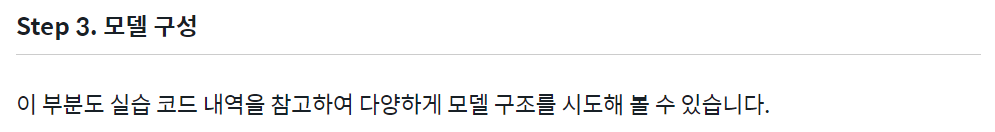

In [78]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [79]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [80]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [81]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [82]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(2048, 1, 20)]           0         
_________________________________________________________________
GRU (GRU)                    [(2048, 50), (2048, 50)]  10800     
_________________________________________________________________
dropout (Dropout)            (2048, 50)                0         
_________________________________________________________________
dense (Dense)                (2048, 20)                1020      
Total params: 11,820
Trainable params: 11,820
Non-trainable params: 0
_________________________________________________________________


In [83]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [84]:
train_model(model, args)


Evaluation:  97%|█████████▋| 30/31 [00:56<00:01,  1.87s/it]


	 - Recall@20 epoch 1: 1.000000
	 - MRR@20    epoch 1: 0.752796



Evaluation:  97%|█████████▋| 30/31 [00:52<00:01,  1.75s/it]


	 - Recall@20 epoch 2: 1.000000
	 - MRR@20    epoch 2: 0.827331



Evaluation:  97%|█████████▋| 30/31 [00:50<00:01,  1.69s/it]

	 - Recall@20 epoch 3: 1.000000
	 - MRR@20    epoch 3: 0.868827



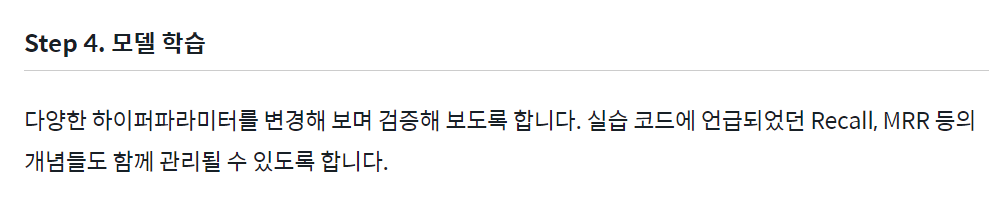

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

변화시키면서 진행 해보기

In [95]:
args_2 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=15, k=20)
model_2 = create_model(args_2) # 에포크 늘리기

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(64, 1, 20)]             0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      10800     
_________________________________________________________________
dropout_7 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_7 (Dense)              (64, 20)                  1020      
Total params: 11,820
Trainable params: 11,820
Non-trainable params: 0
_________________________________________________________________


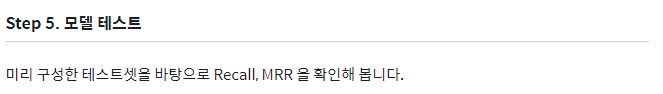

In [87]:
train_model(model_2, args_2)

Evaluation: 100%|█████████▉| 1006/1007 [01:22<00:00, 12.24it/s]


	 - Recall@20 epoch 1: 1.000000
	 - MRR@20    epoch 1: 0.881309



Evaluation: 100%|█████████▉| 1006/1007 [01:21<00:00, 12.34it/s]


	 - Recall@20 epoch 2: 1.000000
	 - MRR@20    epoch 2: 0.881378



Evaluation: 100%|█████████▉| 1006/1007 [01:21<00:00, 12.36it/s]


	 - Recall@20 epoch 3: 1.000000
	 - MRR@20    epoch 3: 0.881231



Evaluation: 100%|█████████▉| 1006/1007 [01:21<00:00, 12.41it/s]


	 - Recall@20 epoch 4: 1.000000
	 - MRR@20    epoch 4: 0.881920



Evaluation: 100%|█████████▉| 1006/1007 [01:21<00:00, 12.36it/s]


	 - Recall@20 epoch 5: 1.000000
	 - MRR@20    epoch 5: 0.881968



Evaluation: 100%|█████████▉| 1006/1007 [01:21<00:00, 12.39it/s]


	 - Recall@20 epoch 6: 1.000000
	 - MRR@20    epoch 6: 0.881966



Evaluation: 100%|█████████▉| 1006/1007 [01:21<00:00, 12.33it/s]


	 - Recall@20 epoch 7: 1.000000
	 - MRR@20    epoch 7: 0.881958



Evaluation: 100%|█████████▉| 1006/1007 [01:21<00:00, 12.35it/s]


	 - Recall@20 epoch 8: 1.000000
	 - MRR@20    epoch 8: 0.881898



Evaluation: 100%|█████████▉| 1006/1007 [01:21<00:00, 12.39it/s]


	 - Recall@20 epoch 9: 1.000000
	 - MRR@20    epoch 9: 0.881966



Evaluation: 100%|█████████▉| 1006/1007 [01:20<00:00, 12.42it/s]


	 - Recall@20 epoch 10: 1.000000
	 - MRR@20    epoch 10: 0.881965



Evaluation: 100%|█████████▉| 1006/1007 [01:21<00:00, 12.35it/s]


	 - Recall@20 epoch 11: 1.000000
	 - MRR@20    epoch 11: 0.881926



Evaluation: 100%|█████████▉| 1006/1007 [01:21<00:00, 12.34it/s]


	 - Recall@20 epoch 12: 1.000000
	 - MRR@20    epoch 12: 0.881989



Evaluation: 100%|█████████▉| 1006/1007 [01:21<00:00, 12.32it/s]


	 - Recall@20 epoch 13: 1.000000
	 - MRR@20    epoch 13: 0.881972



Evaluation: 100%|█████████▉| 1006/1007 [01:21<00:00, 12.38it/s]


	 - Recall@20 epoch 14: 1.000000
	 - MRR@20    epoch 14: 0.881945



Evaluation: 100%|█████████▉| 1006/1007 [01:20<00:00, 12.43it/s]

	 - Recall@20 epoch 15: 1.000000
	 - MRR@20    epoch 15: 0.881926



In [97]:
args_9 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=15, k=20)
model_9 = create_model(args_9) # 에포크 늘리기 # 배치 사이즈 늘리기

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(128, 1, 20)]            0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    10800     
_________________________________________________________________
dropout_9 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_9 (Dense)              (128, 20)                 1020      
Total params: 11,820
Trainable params: 11,820
Non-trainable params: 0
_________________________________________________________________


In [98]:
train_model(model_9, args_9)

Evaluation: 100%|█████████▉| 502/503 [01:07<00:00,  7.44it/s]


	 - Recall@20 epoch 1: 1.000000
	 - MRR@20    epoch 1: 0.880288



Evaluation: 100%|█████████▉| 502/503 [01:07<00:00,  7.45it/s]


	 - Recall@20 epoch 2: 1.000000
	 - MRR@20    epoch 2: 0.881591



Evaluation: 100%|█████████▉| 502/503 [01:07<00:00,  7.47it/s]


	 - Recall@20 epoch 3: 1.000000
	 - MRR@20    epoch 3: 0.881385



Evaluation: 100%|█████████▉| 502/503 [01:06<00:00,  7.51it/s]


	 - Recall@20 epoch 4: 1.000000
	 - MRR@20    epoch 4: 0.881353



Evaluation: 100%|█████████▉| 502/503 [01:06<00:00,  7.50it/s]


	 - Recall@20 epoch 5: 1.000000
	 - MRR@20    epoch 5: 0.881228



Evaluation: 100%|█████████▉| 502/503 [01:06<00:00,  7.51it/s]


	 - Recall@20 epoch 6: 1.000000
	 - MRR@20    epoch 6: 0.881839



Evaluation: 100%|█████████▉| 502/503 [01:06<00:00,  7.53it/s]


	 - Recall@20 epoch 7: 1.000000
	 - MRR@20    epoch 7: 0.881938



Evaluation: 100%|█████████▉| 502/503 [01:05<00:00,  7.61it/s]


	 - Recall@20 epoch 8: 1.000000
	 - MRR@20    epoch 8: 0.881899



Evaluation: 100%|█████████▉| 502/503 [01:06<00:00,  7.52it/s]


	 - Recall@20 epoch 9: 1.000000
	 - MRR@20    epoch 9: 0.881940



Evaluation: 100%|█████████▉| 502/503 [01:06<00:00,  7.57it/s]


	 - Recall@20 epoch 10: 1.000000
	 - MRR@20    epoch 10: 0.881837



Evaluation: 100%|█████████▉| 502/503 [01:06<00:00,  7.59it/s]


	 - Recall@20 epoch 11: 1.000000
	 - MRR@20    epoch 11: 0.881742



Evaluation: 100%|█████████▉| 502/503 [01:06<00:00,  7.59it/s]


	 - Recall@20 epoch 12: 1.000000
	 - MRR@20    epoch 12: 0.881909



Evaluation: 100%|█████████▉| 502/503 [01:06<00:00,  7.59it/s]


	 - Recall@20 epoch 13: 1.000000
	 - MRR@20    epoch 13: 0.881897



Evaluation: 100%|█████████▉| 502/503 [01:08<00:00,  7.36it/s]


	 - Recall@20 epoch 14: 1.000000
	 - MRR@20    epoch 14: 0.881839



Evaluation: 100%|█████████▉| 502/503 [01:09<00:00,  7.26it/s]

	 - Recall@20 epoch 15: 1.000000
	 - MRR@20    epoch 15: 0.881859



In [99]:
args_10 = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=15, k=20)
model_10 = create_model(args_10) # 에포크 늘리기 # 배치 사이즈 줄이기

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(32, 1, 20)]             0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      10800     
_________________________________________________________________
dropout_10 (Dropout)         (32, 50)                  0         
_________________________________________________________________
dense_10 (Dense)             (32, 20)                  1020      
Total params: 11,820
Trainable params: 11,820
Non-trainable params: 0
_________________________________________________________________


In [100]:
train_model(model_10, args_10)

Evaluation: 100%|█████████▉| 2013/2014 [01:51<00:00, 18.06it/s]


	 - Recall@20 epoch 1: 1.000000
	 - MRR@20    epoch 1: 0.881607



Evaluation: 100%|█████████▉| 2013/2014 [01:49<00:00, 18.31it/s]


	 - Recall@20 epoch 2: 1.000000
	 - MRR@20    epoch 2: 0.881541



Evaluation: 100%|█████████▉| 2013/2014 [01:49<00:00, 18.30it/s]


	 - Recall@20 epoch 3: 1.000000
	 - MRR@20    epoch 3: 0.881803



Evaluation: 100%|█████████▉| 2013/2014 [01:50<00:00, 18.27it/s]


	 - Recall@20 epoch 4: 1.000000
	 - MRR@20    epoch 4: 0.882095



Evaluation: 100%|█████████▉| 2013/2014 [01:50<00:00, 18.30it/s]


	 - Recall@20 epoch 5: 1.000000
	 - MRR@20    epoch 5: 0.882103



Evaluation: 100%|█████████▉| 2013/2014 [01:49<00:00, 18.33it/s]


	 - Recall@20 epoch 6: 1.000000
	 - MRR@20    epoch 6: 0.882000



Evaluation: 100%|█████████▉| 2013/2014 [01:50<00:00, 18.28it/s]


	 - Recall@20 epoch 7: 1.000000
	 - MRR@20    epoch 7: 0.882105



Evaluation: 100%|█████████▉| 2013/2014 [01:50<00:00, 18.25it/s]


	 - Recall@20 epoch 8: 1.000000
	 - MRR@20    epoch 8: 0.881956



Evaluation: 100%|█████████▉| 2013/2014 [01:49<00:00, 18.32it/s]


	 - Recall@20 epoch 9: 1.000000
	 - MRR@20    epoch 9: 0.882036



Evaluation: 100%|█████████▉| 2013/2014 [01:50<00:00, 18.16it/s]


	 - Recall@20 epoch 10: 1.000000
	 - MRR@20    epoch 10: 0.882000



Evaluation: 100%|█████████▉| 2013/2014 [01:50<00:00, 18.14it/s]


	 - Recall@20 epoch 11: 1.000000
	 - MRR@20    epoch 11: 0.881991



Evaluation: 100%|█████████▉| 2013/2014 [01:49<00:00, 18.32it/s]


	 - Recall@20 epoch 12: 1.000000
	 - MRR@20    epoch 12: 0.882044



Evaluation: 100%|█████████▉| 2013/2014 [01:49<00:00, 18.34it/s]


	 - Recall@20 epoch 13: 1.000000
	 - MRR@20    epoch 13: 0.882024



Evaluation: 100%|█████████▉| 2013/2014 [01:49<00:00, 18.31it/s]


	 - Recall@20 epoch 14: 1.000000
	 - MRR@20    epoch 14: 0.882020



Evaluation: 100%|█████████▉| 2013/2014 [01:49<00:00, 18.37it/s]

	 - Recall@20 epoch 15: 1.000000
	 - MRR@20    epoch 15: 0.882005



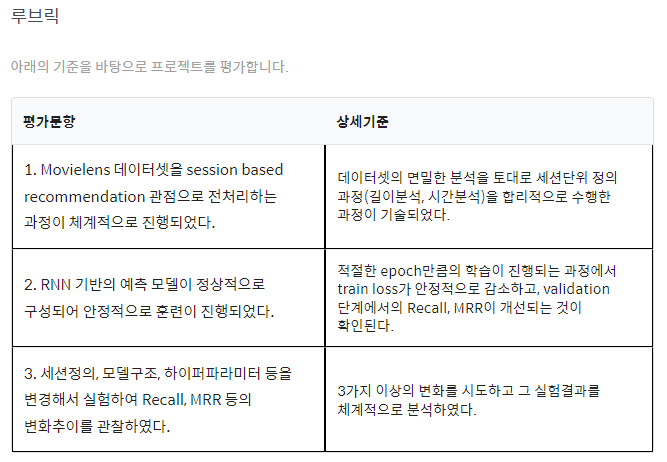

전반적으로 Recall 값은 1이 다 나오게 되었고, 에포크를 늘리고 배치사이즈를 줄이고 늘림에 따라서 MRR값의 개선이 크게 보이지는 않았다.

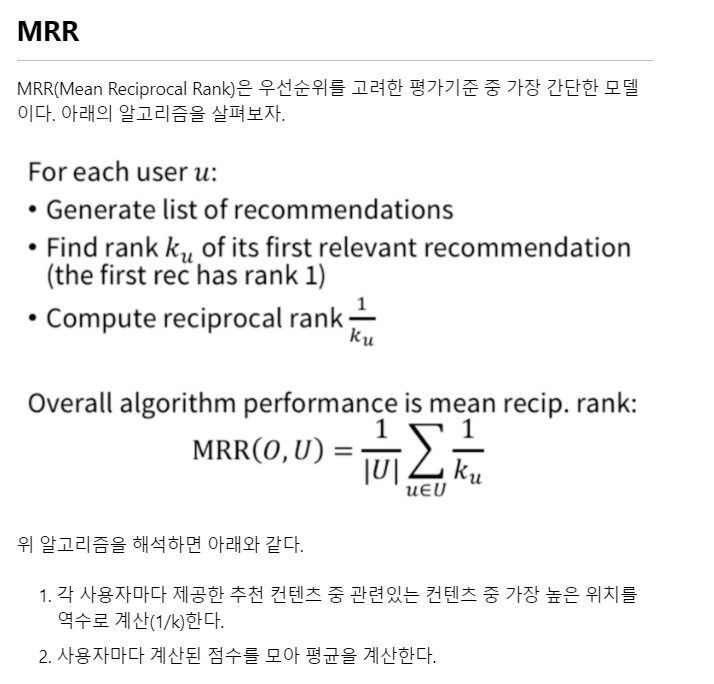

https://lamttic.github.io/2020/03/20/01.html

어려운 부분이었는데, 전반적으로 논문에 대해서 스터디가 필요한거 같고, accuracy, recall 등 지도학습- 분류모델, 회귀모델 등에 대해서 다시 한번 복습을 해야할 필요성을 느꼈다.